In [1]:
import pandas as pd
import json

pd.set_option('display.max_columns', 500)

MARKET = "base_cbbtc_usdc_full"
MARKET = "eth_cbbtc_usdc"
MARKET = "eth_rlp_usdc"


df = pd.read_csv(
    f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/{MARKET}.csv"
)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/markets_meta.json", 'r') as f:
    markets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/assets_meta.json", 'r') as f:
    assets_meta = json.load(f)
market_addr = df["market_address"].unique()[0]
market_meta = markets_meta[market_addr]
asset_meta = assets_meta[market_meta["collateral_asset_address"]]

df.columns

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_51636/1701863384.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Index(['hash', 'type', 'timestamp', 'user_address', 'assets', 'assets_usd',
       'liquidated_assets', 'liquidated_assets_usd', 'market', 'datetime',
       'market_address', 'total_supply_before', 'total_borrow_before',
       'total_supply_after', 'total_borrow_after', 'utilization_before',
       'utilization_after', 'tx_actions', 'borrow_rate_before',
       'supply_rate_before', 'borrow_rate_after', 'supply_rate_after',
       'collateral_price', 'loan_asset_price', 'collateral_before',
       'collateral_value_before', 'debt_before', 'ltv_before',
       'collateral_after', 'collateral_value_after', 'debt_after', 'ltv_after',
       'health_factor_before', 'health_factor_after', 'event_type',
       'vault_flg', 'volatility_1h', 'drawdown_1h', 'trend_1h',
       'volatility_6h', 'drawdown_6h', 'trend_6h', 'volatility_24h',
       'drawdown_24h', 'trend_24h'],
      dtype='object')

In [2]:
markets_meta

{'0xe7e9694b754c4d4f7e21faf7223f6fa71abaeb10296a4c43a54a7977149687d2': {'address': '0xe7e9694b754c4d4f7e21faf7223f6fa71abaeb10296a4c43a54a7977149687d2',
  'lltv': '860000000000000000',
  'oracle_address': '0x95DB30fAb9A3754e42423000DF27732CB2396992',
  'creation_datetime': 1706722763,
  'network': 'eth',
  'loan_asset_address': '0xdAC17F958D2ee523a2206206994597C13D831ec7',
  'loan_asset_symbol': 'USDT',
  'loan_asset_decimals': 6,
  'collateral_asset_address': '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0',
  'collateral_asset_symbol': 'wstETH',
  'collateral_asset_decimals': 18,
  'rate_at_target': {'1771765200': 870727320,
   '1771761600': 870386066,
   '1771758000': 869983867,
   '1771754400': 869543822,
   '1771750800': 869080593,
   '1771747200': 868438574,
   '1771743600': 867274300,
   '1771740000': 866146612,
   '1771736400': 865991166,
   '1771732800': 865483018,
   '1771729200': 864484795,
   '1771725600': 863640535,
   '1771722000': 862693297,
   '1771718400': 862023575,
   '1

In [3]:
df.head(1).to_dict()
from tqdm.auto import tqdm
import numpy as np
def create_market_hourly_dataset(df, asset_meta):
    # Generate hourly timestamps
    min_time = df['timestamp'].min()
    max_time = df['timestamp'].max()
    
    start_hour = (min_time // 3600) * 3600
    end_hour = ((max_time // 3600) + 1) * 3600
    
    hourly_ts = np.arange(start_hour, end_hour + 3600, 3600)
    
    # Sort events
    df_sorted = df.sort_values('timestamp')
    events_ts = df_sorted['timestamp'].values
    
    # Find last event index for each hour using searchsorted
    idx = np.searchsorted(events_ts, hourly_ts, side='right') - 1
    
    # Extract values
    result_data = []
    for i, hour_ts in tqdm(enumerate(hourly_ts)):
        if idx[i] >= 0:
            last_row = df_sorted.iloc[idx[i]]
            row_data = {
                'timestamp': hour_ts,
                'datetime': pd.to_datetime(hour_ts, unit='s'),
                'total_supply': last_row['total_supply_after'],
                'total_borrow': last_row['total_borrow_after'],
                'utilization': last_row['utilization_after'],
                'borrow_rate': last_row['borrow_rate_after'],
                'supply_rate': last_row['supply_rate_after'],
                'volatility_1h': last_row.get('volatility_1h', 0),
                'drawdown_1h': last_row.get('drawdown_1h', 0),
                'volatility_6h': last_row.get('volatility_6h', 0),
                'drawdown_6h': last_row.get('drawdown_6h', 0),
                'collateral_price': last_row.get('collateral_price', 0),
                'loan_asset_price': last_row.get('loan_asset_price', 0),
                'avg_health_factor': last_row.get('health_factor_after', 0)
            }
        else:
            row_data = {
                'timestamp': hour_ts,
                'datetime': pd.to_datetime(hour_ts, unit='s'),
                'total_supply': 0,
                'total_borrow': 0,
                'utilization': 0,
                'borrow_rate': 0,
                'supply_rate': 0,
                'volatility_1h': 0,
                'drawdown_1h': 0,
                'volatility_6h': 0,
                'drawdown_6h': 0,
                'collateral_price': 0,
                'loan_asset_price': 0,
                'avg_health_factor': 0
            }
        result_data.append(row_data)
    
    result_df = pd.DataFrame(result_data)
    
    # Forward fill
    result_df = result_df.ffill().fillna(0)
    
    # Add asset price
    if 'historical_price' in asset_meta and asset_meta['historical_price']:
        price_df = pd.DataFrame(asset_meta['historical_price'], columns=['timestamp', 'price'])
        price_df = price_df.dropna()
        if not price_df.empty:
            result_df = result_df.merge(price_df, on='timestamp', how='left')
            result_df['asset_price'] = result_df['price'].ffill().fillna(0)
            result_df = result_df.drop(columns=['price'])
    
    return result_df
hourly_df = create_market_hourly_dataset(
    df,
    asset_meta,
)

0it [00:00, ?it/s]

<Axes: >

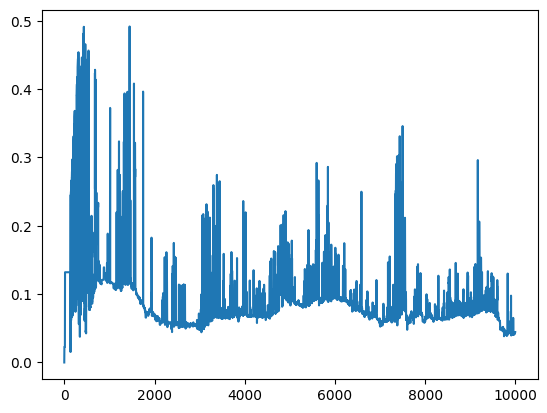

In [4]:
hourly_df["borrow_rate"].plot()
# hourly_df["total_supply"].plot()

In [5]:
hourly_df["borrow_rate"]
# hourly_df.head(2)

df[df["datetime"]>"2025-12-01"]["borrow_rate_after"]

39439    0.058671
39440    0.058688
39441    0.058623
39442    0.058553
39443    0.058553
           ...   
56180    0.042721
56181    0.044577
56182    0.044528
56183    0.044529
56184    0.044523
Name: borrow_rate_after, Length: 16746, dtype: float64

In [6]:
hourly_df.to_csv(f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_hourly_data/{MARKET}.csv",index=False)


In [8]:
hourly_df["datetime"].max()

Timestamp('2026-02-22 14:00:00')